## Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [10]:
df.head()

,text,label
0,"@first_timee хоть я и школота, но поверь, у на...",positive
1,"Да, все-таки он немного похож на него. Но мой ...",positive
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,positive
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",positive
4,@irina_dyshkant Вот что значит страшилка :D\nН...,positive


In [5]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

#### Baseline

In [6]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)

In [8]:
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/Users/maximdoroshenko/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.76      0.76      0.76     27990
    positive       0.76      0.77      0.77     28719

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



#### Определение частоты токенов

In [89]:
from collections import Counter
from razdel import tokenize
from string import punctuation
import re

In [20]:
corpus = [token.text for text in df.text for token in tokenize(text) if token.text not in punctuation]
print(len(corpus))
corpus[:10]

3135394


['first_timee', 'хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то']

In [23]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 69603),
 ('и', 55347),
 ('я', 53243),
 ('в', 53038),
 ('RT', 38080),
 ('на', 35812),
 ('t', 33561),
 ('http', 33072),
 ('co', 33041),
 (':(', 32776)]

In [109]:
vec = CountVectorizer(ngram_range=(1, 1), min_df=1000)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.63      0.63      0.63     28014
    positive       0.64      0.64      0.64     28695

    accuracy                           0.63     56709
   macro avg       0.63      0.63      0.63     56709
weighted avg       0.63      0.63      0.63     56709



In [110]:
vec = CountVectorizer(ngram_range=(1, 1), min_df=100, max_df=1000)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.56      0.69      0.62     22571
    positive       0.76      0.64      0.70     34138

    accuracy                           0.66     56709
   macro avg       0.66      0.67      0.66     56709
weighted avg       0.68      0.66      0.67     56709



In [111]:
vec = CountVectorizer(ngram_range=(1, 1), max_df=100)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/Users/maximdoroshenko/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.73      0.66      0.70     30879
    positive       0.64      0.71      0.67     25830

    accuracy                           0.68     56709
   macro avg       0.69      0.69      0.68     56709
weighted avg       0.69      0.68      0.69     56709



#### Токены со средней частотой лучше в определении позитивных сообщений, а с меньшей частотой (до 100 в корпусе) - негативных. При использовании часто встречающихся токенов f1 score падает. Видимо по причине потери уникальности текстов.

## Задание 2.
найти фичи с наибольшей значимостью, и вывести их

In [151]:
feature_importances = clf.coef_[0]

In [152]:
feature_names = vec.get_feature_names()

In [155]:
df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
df = df.sort_values('importance', ascending=False)
df['feature'][:30].tolist()

['ddddd',
 'улыбнуло',
 'dtoropova',
 'отличного',
 'прекрасного',
 'читатель',
 'juljulianapai',
 'удачного',
 'vxt6clfpdd',
 'omega777oleg',
 'кайфую',
 'смеха',
 'украсить',
 'предвкушении',
 'полезно',
 'today_okay',
 'красавчик',
 'добре',
 'азазаз',
 'выиграли',
 'успехов',
 'забавно',
 'прекрасны',
 'поздравляем',
 'gregwest_',
 'респект',
 'вечернийургант',
 'прекрасна',
 'читателю',
 'постепенно']

### Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера 

3) убедиться что для сетки нет переобучения

In [156]:
# CountVectorizer

vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/Users/maximdoroshenko/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.76      0.76      0.76     27990
    positive       0.76      0.77      0.77     28719

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



In [158]:
# TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/Users/maximdoroshenko/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.73      0.77      0.75     26731
    positive       0.78      0.75      0.77     29978

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



In [159]:
# HashingVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

vec = HashingVectorizer(n_features=4)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.41      0.51      0.45     22065
    positive       0.63      0.52      0.57     34644

    accuracy                           0.52     56709
   macro avg       0.52      0.52      0.51     56709
weighted avg       0.54      0.52      0.53     56709



In [208]:
# NN
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Conv1D, GRU, LSTM, Dropout, SimpleRNN

In [185]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df.text)
sequences = tokenizer.texts_to_sequences(df.text)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ... 3340 2953  527]
 [   0    0    0 ...  178  121   20]
 [   0    0    0 ... 3903   26   40]
 ...
 [   0    0    0 ...  221   27   53]
 [   0    0    0 ...    6    1 2354]
 [   0    0    0 ...    5   16   36]]


In [231]:
labels = np.where(df.label == 'positive', 1, 0)

array([1, 1, 1, ..., 0, 0, 0])

In [232]:
x_train, x_test, y_train, y_test = train_test_split(tweets, labels)

In [211]:
from keras.backend import clear_session
clear_session()

In [216]:
maxlen = max_len

In [217]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 50)           250000    
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 10)                100010    
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 350,021
Trainable params: 350,021
Non-trainable params: 0
_________________________________________________________________


In [244]:
history = model.fit(x_train, y_train,
                    epochs=5,
                    verbose=True,
                    validation_data=(x_test, y_test),
                    batch_size=10)

Epoch 1/5
17013/17013 [==============================] - 46s 3ms/step - loss: 0.6931 - accuracy: 0.5064 - val_loss: 0.6931 - val_accuracy: 0.5055
Epoch 2/5
17013/17013 [==============================] - 48s 3ms/step - loss: 0.6931 - accuracy: 0.5055 - val_loss: 0.6931 - val_accuracy: 0.5055
Epoch 3/5
17013/17013 [==============================] - 50s 3ms/step - loss: 0.6931 - accuracy: 0.5061 - val_loss: 0.6931 - val_accuracy: 0.5055
Epoch 4/5
17013/17013 [==============================] - 48s 3ms/step - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6931 - val_accuracy: 0.5055
Epoch 5/5
17013/17013 [==============================] - 47s 3ms/step - loss: 0.6931 - accuracy: 0.5054 - val_loss: 0.6931 - val_accuracy: 0.5055


In [242]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Training Accuracy: 0.5070
Testing Accuracy:  0.5055


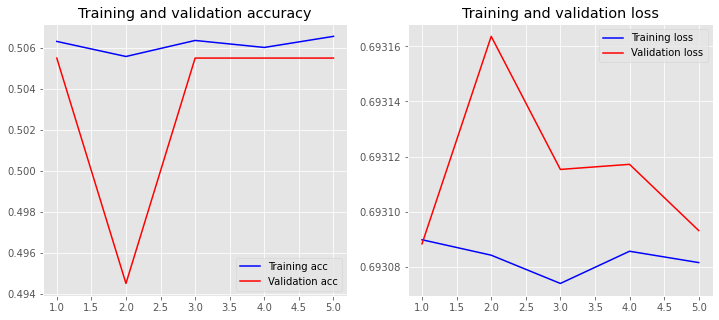

In [243]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [247]:
embedding_dim = 20

In [250]:
clear_session()

In [251]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.LSTM(embedding_dim))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 20)           100000    
                                                                 
 lstm (LSTM)                 (None, 20)                3280      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 103,301
Trainable params: 103,301
Non-trainable params: 0
_________________________________________________________________


In [252]:
history = model.fit(x_train, y_train,
                    epochs=3,
                    verbose=True,
                    validation_data=(x_test, y_test),
                    batch_size=500)

Epoch 1/3
341/341 [==============================] - 63s 180ms/step - loss: 0.5503 - accuracy: 0.7151 - val_loss: 0.4903 - val_accuracy: 0.7537
Epoch 2/3
341/341 [==============================] - 62s 183ms/step - loss: 0.4749 - accuracy: 0.7653 - val_loss: 0.4844 - val_accuracy: 0.7586
Epoch 3/3
341/341 [==============================] - 65s 191ms/step - loss: 0.4668 - accuracy: 0.7701 - val_loss: 0.4827 - val_accuracy: 0.7583


Training Accuracy: 0.7806
Testing Accuracy:  0.7583


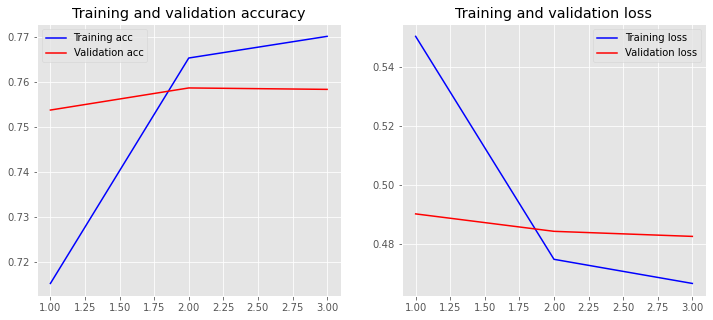

In [253]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [254]:
clear_session()

In [ ]:
embedding_dim=200

model = Sequential([
    vectorize_layer,
    Embedding(vocab_size, embedding_dim),
    Conv1D(200, (3)),
    Conv1D(200, (2)),
    GRU(300),
    #GlobalAveragePooling1D(),
    Dense(100, activation='relu'),
    Dense(1)
])

In [257]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Conv1D(200, (3)))
model.add(layers.Conv1D(200, (2)))
model.add(layers.GRU(300)),
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 20)           100000    
                                                                 
 conv1d (Conv1D)             (None, 198, 200)          12200     
                                                                 
 conv1d_1 (Conv1D)           (None, 197, 200)          80200     
                                                                 
 gru (GRU)                   (None, 300)               451800    
                                                                 
 dense (Dense)               (None, 100)               30100     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 674,401
Trainable params: 674,401
Non-trai

In [259]:
# history = model.fit(x_train, y_train,
#                     epochs=3,
#                     verbose=True,
#                     validation_data=(x_test, y_test),
#                     batch_size=500)

#### Вывод: вторая нейронная сеть - самая оптимальная из рассмотренных. На второй эпохе уже наблюдается переобучение.
Третья нейронная сеть обрабатывалась слишком долго и показывала результаты чуть хуже второй.

#### Подобрать оптимальный размер для hashing векторайзера

In [262]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

In [265]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [271]:
n_features = range(2, 50, 3)

In [272]:
pipeline = Pipeline(steps=[('vec', HashingVectorizer()),
                           ('clf', LogisticRegression())])

In [279]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vec', 'clf', 'vec__alternate_sign', 'vec__analyzer', 'vec__binary', 'vec__decode_error', 'vec__dtype', 'vec__encoding', 'vec__input', 'vec__lowercase', 'vec__n_features', 'vec__ngram_range', 'vec__norm', 'vec__preprocessor', 'vec__stop_words', 'vec__strip_accents', 'vec__token_pattern', 'vec__tokenizer', 'clf__C', 'clf__class_weight', 'clf__dual', 'clf__fit_intercept', 'clf__intercept_scaling', 'clf__l1_ratio', 'clf__max_iter', 'clf__multi_class', 'clf__n_jobs', 'clf__penalty', 'clf__random_state', 'clf__solver', 'clf__tol', 'clf__verbose', 'clf__warm_start'])

In [280]:
parameters = dict(vec__n_features=n_features)

In [281]:
gs = GridSearchCV(pipeline, parameters)
gs.fit(df.text, df.label)

GridSearchCV(estimator=Pipeline(steps=[('vec', HashingVectorizer()),
                                       ('clf', LogisticRegression())]),
             param_grid={'vec__n_features': range(2, 50, 3)})

In [282]:
print('Best number of features:', gs.best_estimator_.get_params()['vec__n_features'])

Best number of features: 44


In [283]:
gs.best_score_

0.5751033690552952

In [284]:
# HashingVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

vec = HashingVectorizer(n_features=44)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.55      0.57      0.56     27122
    positive       0.60      0.58      0.59     29587

    accuracy                           0.58     56709
   macro avg       0.58      0.58      0.58     56709
weighted avg       0.58      0.58      0.58     56709



#### Вывод: с помощью GridSearchCV удалось выявить оптимальный размер hashing векторайзера = 44.
Можно также проверить значения после 50.